<a href="https://colab.research.google.com/github/prashansapandey2005/Custom-Made-Classifier/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os

# List the contents of the root of MyDrive to ensure the folder is there
print(os.listdir('/content/drive/MyDrive'))

['Colab Notebooks', 'cat_to_name.json', 'flower_data.gz']


In [ ]:
import tarfile

# Path to your tar.gz file on Google Drive
tar_path = '/content/drive/MyDrive/flower_data.gz'

# Extract to a directory
extract_path = '/content/flower_data'

with tarfile.open(tar_path, 'r:gz') as tar_ref:
    tar_ref.extractall(extract_path)

print("Dataset extracted successfully.")


Dataset extracted successfully.


In [ ]:
import json

# Set the correct path to your cat_to_name.json file
cat_to_name_path = '/content/drive/MyDrive/cat_to_name.json'

# Load the class to name mapping
with open(cat_to_name_path, 'r') as f:
    cat_to_name = json.load(f)

print("Class to name mapping loaded successfully.")



Class to name mapping loaded successfully.


In [ ]:
# Download the dataset
# This cell has to run only once.
# NO need to run every time you arrive on this notebook.
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.
import requests
import tarfile
import os
import shutil

# Define the URL and folder paths
url = "https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz"
folder_name = "flowers"
file_name = "flower_data.tar.gz"
file_path = os.path.join(folder_name, file_name)

# Remove the folder or symbolic link if it already exists (equivalent to `rm -rf flowers`)
try:
    if os.path.islink(folder_name) or os.path.isfile(folder_name):
        os.remove(folder_name)  # Remove the symbolic link or file
    elif os.path.isdir(folder_name):
        shutil.rmtree(folder_name)  # Remove the directory
    print(f"Removed existing {folder_name} folder/file/soft link, if any.")
except FileNotFoundError:
    pass  # If the file or directory does not exist, do nothing

# Create the folder
os.makedirs(folder_name)
print(f"Created folder: {folder_name}")

# Download the file
response = requests.get(url, stream=True)

# Save the file in the 'flowers' folder
with open(file_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print(f"Downloaded {file_name} to {folder_name}")

# Extract the file in the 'flowers' folder
if file_path.endswith("tar.gz"):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=folder_name)
        print(f"Extracted {file_name} to {folder_name}")

# Clean up by removing the tar.gz file after extraction
os.remove(file_path)
print(f"Removed the downloaded tar.gz file: {file_path}")

2.5.1+cu121
True
Removed existing flowers folder/file/soft link, if any.
Created folder: flowers
Downloaded flower_data.tar.gz to flowers
Extracted flower_data.tar.gz to flowers
Removed the downloaded tar.gz file: flowers/flower_data.tar.gz


In [ ]:
# Basic Python libraries
import numpy as np
import json
import os
import shutil
import argparse
from PIL import Image
import requests
import tarfile

# PyTorch libraries and modules
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models

# Additional imports for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set Matplotlib to display inline in Jupyter notebooks
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

print("All necessary packages imported.")


All necessary packages imported.


In [ ]:
# Define data directories
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=64)
}

print("Executed successfully.")


Executed successfully.


In [ ]:
with open(cat_to_name_path, 'r') as f:
    cat_to_name = json.load(f)

print("Class to name mapping loaded successfully.")

Class to name mapping loaded successfully.


In [ ]:
# Load a pre-trained network (e.g., VGG16)
model = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
classifier = nn.Sequential(
    nn.Linear(25088, 1024),  # Correct input size to match VGG16 features
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 102),
    nn.LogSoftmax(dim=1)
)
model.classifier = classifier

print("Classifier built successfully.")




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 124MB/s] 


Classifier built successfully.


In [ ]:
# Define the loss function and the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
print("Loss function and optimizer set.")

Loss function and optimizer set.


In [ ]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model moved to device:", device)

# Train the classifier layers using backpropagation
epochs = 20
steps = 0
running_loss = 0
print_every = 5

# Load from the last checkpoint if it exists
try:
    checkpoint = load_checkpoint('checkpoint.pth.tar')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found, starting from scratch")

print("Starting training...")

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in dataloaders['train']:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()
            validation_loss = 0
            accuracy = 0

            with torch.no_grad():
                for inputs, labels in dataloaders['valid']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model.forward(inputs)
                    batch_loss = criterion(outputs, labels)
                    validation_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(outputs)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {validation_loss/len(dataloaders['valid']):.3f}.. "
                  f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")

            running_loss = 0
            model.train()

print("Training complete.")


Model moved to device: cuda
Starting training...
Epoch 1/20.. Train loss: 4.656.. Validation loss: 4.378.. Validation accuracy: 0.128
Epoch 1/20.. Train loss: 4.307.. Validation loss: 3.976.. Validation accuracy: 0.217
Epoch 1/20.. Train loss: 4.010.. Validation loss: 3.465.. Validation accuracy: 0.256
Epoch 1/20.. Train loss: 3.623.. Validation loss: 3.066.. Validation accuracy: 0.363
Epoch 1/20.. Train loss: 3.453.. Validation loss: 2.720.. Validation accuracy: 0.402
Epoch 1/20.. Train loss: 3.156.. Validation loss: 2.388.. Validation accuracy: 0.485
Epoch 1/20.. Train loss: 2.815.. Validation loss: 2.169.. Validation accuracy: 0.494
Epoch 1/20.. Train loss: 2.615.. Validation loss: 1.798.. Validation accuracy: 0.552
Epoch 1/20.. Train loss: 2.280.. Validation loss: 1.686.. Validation accuracy: 0.587
Epoch 1/20.. Train loss: 2.262.. Validation loss: 1.516.. Validation accuracy: 0.586
Epoch 1/20.. Train loss: 2.128.. Validation loss: 1.441.. Validation accuracy: 0.588
Epoch 1/20.. Tra

In [ ]:
import torch

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='checkpoint.pth.tar'):
    return torch.load(filename)


In [ ]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model moved to device:", device)

# Train the classifier layers using backpropagation
epochs = 10
steps = 0
running_loss = 0
print_every = 5

# Load from the last checkpoint if it exists
try:
    checkpoint = load_checkpoint('checkpoint.pth.tar')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found, starting from scratch")

print("Starting training...")

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in dataloaders['train']:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()
            validation_loss = 0
            accuracy = 0

            with torch.no_grad():
                for inputs, labels in dataloaders['valid']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model.forward(inputs)
                    batch_loss = criterion(outputs, labels)
                    validation_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(outputs)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {validation_loss/len(dataloaders['valid']):.3f}.. "
                  f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")

            running_loss = 0
            model.train()
            # Save the checkpoint after each epoch
    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    save_checkpoint(checkpoint, 'checkpoint.pth.tar')

print("Training complete.")


Model moved to device: cuda
No checkpoint found, starting from scratch
Starting training...


<ipython-input-17-0c12e7d8c582>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(filename)


Epoch 1/10.. Train loss: 0.395.. Validation loss: 0.483.. Validation accuracy: 0.883
Epoch 1/10.. Train loss: 0.558.. Validation loss: 0.427.. Validation accuracy: 0.890
Epoch 1/10.. Train loss: 0.426.. Validation loss: 0.411.. Validation accuracy: 0.900
Epoch 1/10.. Train loss: 0.428.. Validation loss: 0.403.. Validation accuracy: 0.907
Epoch 1/10.. Train loss: 0.463.. Validation loss: 0.405.. Validation accuracy: 0.913
Epoch 1/10.. Train loss: 0.472.. Validation loss: 0.400.. Validation accuracy: 0.908
Epoch 1/10.. Train loss: 0.357.. Validation loss: 0.402.. Validation accuracy: 0.900
Epoch 1/10.. Train loss: 0.460.. Validation loss: 0.420.. Validation accuracy: 0.895
Epoch 1/10.. Train loss: 0.489.. Validation loss: 0.409.. Validation accuracy: 0.905
Epoch 1/10.. Train loss: 0.662.. Validation loss: 0.388.. Validation accuracy: 0.915
Epoch 1/10.. Train loss: 0.373.. Validation loss: 0.396.. Validation accuracy: 0.910
Epoch 1/10.. Train loss: 0.504.. Validation loss: 0.387.. Validat

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track the test loss and accuracy
test_loss = 0
accuracy = 0

# Use torch.no_grad() since we are only doing inference
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        # Move inputs and labels to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Update the test loss
        test_loss += loss.item()

        # Calculate accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

# Print the results
print(f"Test loss: {test_loss/len(dataloaders['test']):.3f}.. "
      f"Test accuracy: {accuracy/len(dataloaders['test']):.3f}")

print("Testing completed successfully.")


Test loss: 0.403.. Test accuracy: 0.910
Testing completed successfully.


In [ ]:
# Define the classifier architecture that matches your current model
classifier = nn.Sequential(
    nn.Linear(25088, 1024),  # Correct input size to match VGG16 features
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 102),
    nn.LogSoftmax(dim=1)
)
model.classifier = classifier

# Ensure this code is run after each epoch
checkpoint = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Ensure this key is included
    'class_to_idx': model.class_to_idx
}
torch.save(checkpoint, '/content/drive/MyDrive/checkpoint.pth.tar')


In [ ]:
import torch
from torchvision import models

def load_checkpoint(filepath):
    """
    Load a checkpoint and rebuild the model.
    """
    checkpoint = torch.load(filepath)

    # Load the pretrained model
    model = models.vgg16(pretrained=True)  # or checkpoint['arch'] if stored in the checkpoint

    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # Re-create the classifier
    classifier = nn.Sequential(
    nn.Linear(25088, 1024),  # Correct input size to match VGG16 features
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 102),
    nn.LogSoftmax(dim=1)
    )

    # Assign the classifier to the model
    model.classifier = classifier

    # Load the trained state_dict
    model.load_state_dict(checkpoint['state_dict'])

    # Load other components
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = optim.Adam(model.classifier.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

# Use the function to load the model and optimizer
model, optimizer = load_checkpoint('/content/drive/MyDrive/checkpoint.pth.tar')
print("Checkpoint loaded and model rebuilt successfully.")


<ipython-input-32-80dcf4ba38a5>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Checkpoint loaded and model rebuilt successfully.


In [ ]:
# 10. Process Image

def process_image(image_path):

    pil_image = Image.open(image_path)
    preprocess = transforms.Compose([

        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        ])
    img_tensor = preprocess(pil_image)

    return img_tensor

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    if title is not None:
        ax.set_title(title)

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

<Axes: >

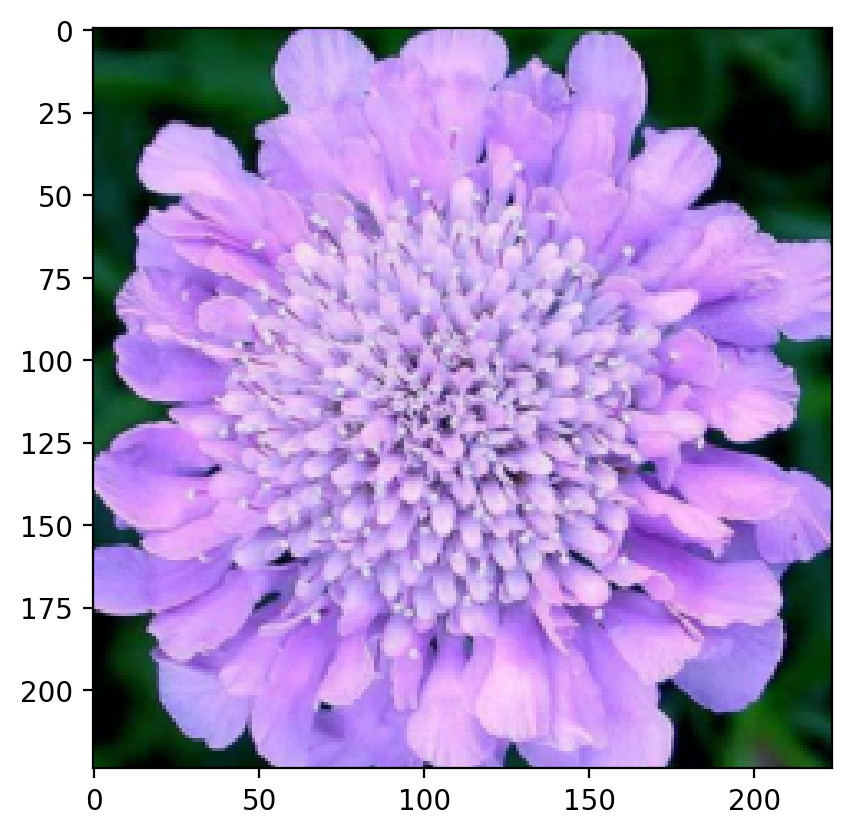

In [ ]:
image = process_image('flowers/test/22/image_05360.jpg')
imshow(image)

In [ ]:

# Assuming `image` is already a Tensor
type(image)
print(image.shape)

# Directly convert to FloatTensor if it's not already
image2 = image.type(torch.FloatTensor)
print(image2.shape)

# Add the extra batch dimension
image3 = image2.unsqueeze(0)
print(image3.shape)


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Numpy array
    '''
    pil_image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    tensor_image = preprocess(pil_image)
    return tensor_image.numpy()


In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained model.
    '''
    # Process the input image
    image = process_image(image_path)

    # Convert to a torch tensor
    image = torch.from_numpy(image).type(torch.FloatTensor)

    # Add a batch dimension
    image = image.unsqueeze(0)

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        output = model(image)
        probs, indices = torch.topk(output, topk)
        probs = torch.exp(probs)

    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in indices[0].tolist()]

    return probs[0].tolist(), classes

# Example usage
image_path = 'flowers/test/22/image_05360.jpg'  # Update with the path to your image
probs, classes = predict(image_path, model)
print(probs)
print(classes)


[0.012774718925356865, 0.011478419415652752, 0.011430616490542889, 0.011386769823729992, 0.011311347596347332]
['51', '12', '37', '83', '18']


Processed image shape: (3, 224, 224)
Tensor image shape: torch.Size([3, 224, 224])
Batch tensor shape: torch.Size([1, 3, 224, 224])
Moved image to device: cuda
Predicted probabilities: tensor([[0.0128, 0.0115, 0.0114, 0.0114, 0.0113]], device='cuda:0')
Predicted classes: ['51', '12', '37', '83', '18']
[0.012774718925356865, 0.011478419415652752, 0.011430616490542889, 0.011386769823729992, 0.011311347596347332]
['51', '12', '37', '83', '18']
['petunia', "colt's foot", 'cape flower', 'hibiscus', 'peruvian lily']


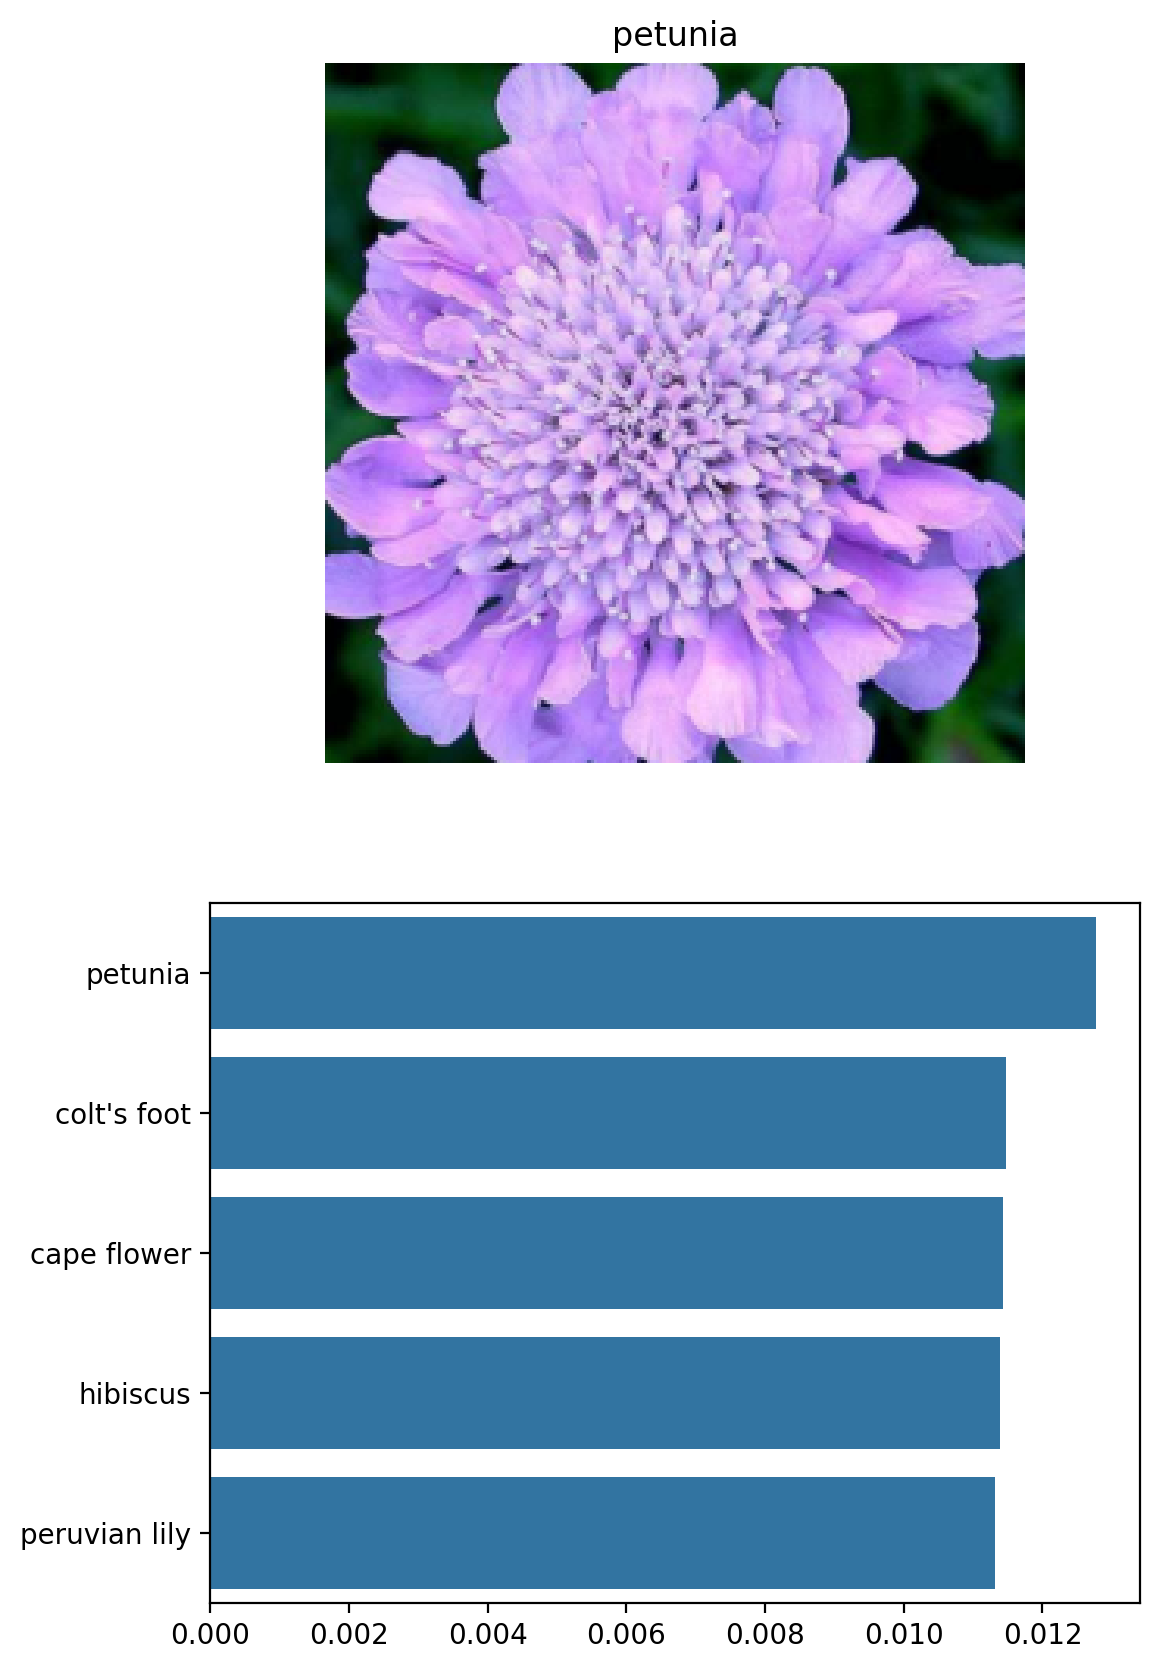

In [ ]:
import torch
from torch import nn

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained model. '''
    try:
        # Process the input image
        image = process_image(image_path)
        print("Processed image shape:", image.shape)

        # Convert to a torch tensor
        image = torch.from_numpy(image).type(torch.FloatTensor)
        print("Tensor image shape:", image.shape)

        # Add a batch dimension
        image = image.unsqueeze(0)
        print("Batch tensor shape:", image.shape)

        # Move the model to the appropriate device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        image = image.to(device)
        print("Moved image to device:", device)

        # Set the model to evaluation mode
        model.eval()

        with torch.no_grad():
            output = model(image)
            probs, indices = torch.topk(output, topk)
            probs = torch.exp(probs)

        # Convert indices to classes
        idx_to_class = {val: key for key, val in model.class_to_idx.items()}
        classes = [idx_to_class[idx] for idx in indices[0].tolist()]

        print("Predicted probabilities:", probs)
        print("Predicted classes:", classes)

        return probs[0].tolist(), classes
    except Exception as e:
        print(f"An error occurred in the predict function: {e}")
        return None

# Example usage
image_path = 'flowers/test/22/image_05360.jpg'  # Update with the path to your image
probs, classes = predict(image_path, model, 5)

# Check if the predict function returned valid results
if probs is not None and classes is not None:
    names = [cat_to_name[key] for key in classes]

    print(probs)
    print(classes)
    print(names)

    plt.figure(figsize=(6, 10))

    ax = plt.subplot(2, 1, 1)
    image = process_image(image_path)
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    ax = imshow(image_tensor, ax=ax, title=names[0])
    ax.axis('off')

    plt.subplot(2, 1, 2)
    sb.barplot(x=probs, y=names, color=sb.color_palette()[0])

    plt.show()
else:
    print("Prediction failed. Please check the predict function.")